# Title: csck700_bsdd_enrichment

### The bsdd_enrichment Python module queries the buildingSMART Data Dictionary (bSDD) API to retrieve canonical metadata for technical properties and ensures semantic alignment. It creates extended property sets when not present in the IFC database and links new properties to them, or, when property sets already exist, it connects the enriched properties directly to the corresponding IfcPropertySet in the graph.

In [1]:
from IPython.display import Image, display

In [2]:
picture_path = r"..\references\graph_enrichment_layer.jpg"

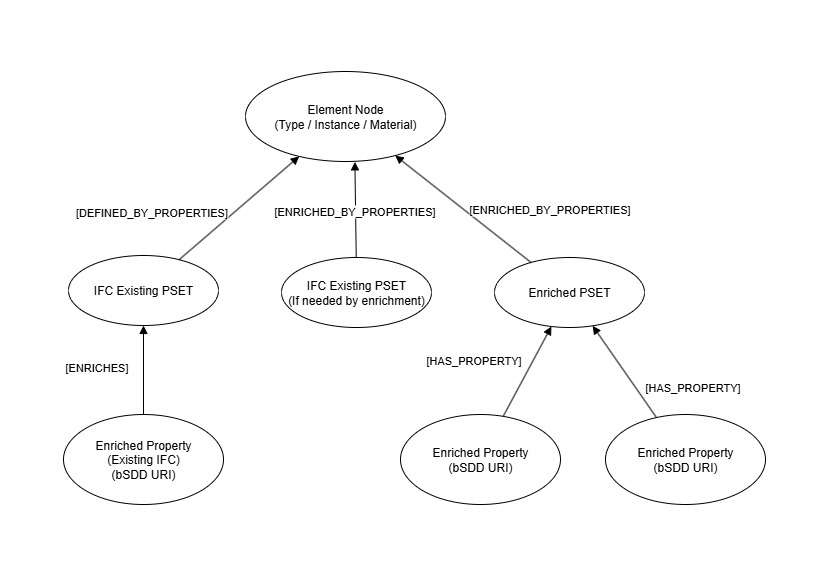

In [3]:
display(Image(filename=picture_path))

# 0. Table of content:

- [1. Settings:](#1.-Settings:)
- [2. Imports:](#2.-Imports:)
- [3. Helper functions:](#3.-Helper-functions:)
- [4. Data load:](#4.-Data-load:)  
- [5. bsDD preparation:](#5.-bsDD-preparation:)
- [6. Graph enrichment:](#6.-Graph-enrichment:)  

# 1. Settings:

In [4]:
BASE = "https://api.bsdd.buildingsmart.org"
IFC43 = "https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3"
ETIM = "https://identifier.buildingsmart.org/uri/etim/etim/10.0"
HEADERS = {
    "accept": "application/json",
    "user-agent": "BenoitCapstone/1.0"
}
TIMEOUT = 30

# 2. Imports:

In [44]:
# !pip install pandas
import pandas as pd
from pandas import StringDtype
# !pip install openpyxl
import openpyxl
import warnings
warnings.simplefilter("ignore", UserWarning)
import requests
from requests.adapters import HTTPAdapter, Retry
import time
import re
# !pip install rapidfuzz
from rapidfuzz import fuzz
import json

# 3. Helper functions:

# 4. Data load:

In [6]:
file_path = r"..\data\raw\authoring.xlsx"

In [7]:
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print(sheet_names)

['description', 'dictionary_keys', 'data_validation', 'stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']


In [8]:
df_names = sheet_names[3:]

In [9]:
dfs = dict()
for df_name in df_names:
    dfs[df_name] = pd.read_excel(file_path, sheet_name=df_name)

In [10]:
for name, df in dfs.items():
    print(f"\n### Dataframe: {name} ###")
    display(df.head(10))


### Dataframe: stone_wall_chimney ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN



### Dataframe: roof_wood_beam ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beam_001,Roof Wood Beam,IfcBeam,species,douglas fir-larch,=,douglas fir-larch,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
1,beam_002,Roof Wood Beam,IfcBeam,grade,No.1,=,No.1,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
2,beam_003,Roof Wood Beam,IfcBeam,moisture content,≤ 19%,≤,19,%,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
3,beam_004,Roof Wood Beam,IfcBeam,fire retardant treatment,Pass,=,Pass,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,ASTM E84,NaN,NaN,NaN
4,beam_005,Roof Wood Beam,IfcBeam,preservative treatment,CCA,=,CCA,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,AWPA U1,NaN,NaN,NaN
5,beam_007,Roof Wood Beam,IfcBeam,straightness tolerance,"Lumber shall be free from bow, crook, twist, a...",enum,"{""bow_mm_per_2.4m"": 6, ""crook_mm_per_2.4m"": 6,...",NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,WWPA / NLGA,NaN,NaN,NaN
6,beam_008,Roof Wood Beam,IfcBeam,bending strength,11.0 Mpa,=,11,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
7,beam_009,Roof Wood Beam,IfcBeam,elastic modulus,"12,400 Mpa",=,12400,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
8,beam_010,Roof Wood Beam,IfcBeam,bearing length,≥ 90 mm,≥,90,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN
9,beam_011,Roof Wood Beam,IfcBeam,spacing (on center),600 mm,=,600,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN



### Dataframe: strip_footing ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,footing_001,Strip Footing,IfcFooting,compressive strength,28 MPa,=,28,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 01,"§2.5.1, §3.14.3.4",ASTM C39,NaN,NaN,NaN
1,footing_002,Strip Footing,IfcFooting,slump,75 ± 25 mm,=,75 ± 25,mm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.14.3.1,ASTM C143,NaN,NaN,NaN
2,footing_003,Strip Footing,IfcFooting,water cement ratio,0.45,≤,0.45,w/cm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.5.2.6,"ACI 211.1, ACI 211.2",NaN,NaN,NaN
3,footing_004,Strip Footing,IfcFooting,nominal maximum aggregate size,25 mm,≤,25,mm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.3.3.1,ASTM C33,NaN,NaN,NaN
4,footing_006,Strip Footing,IfcFooting,rebar grade,grade 60,=,grade 60,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.6.1,ASTM A615,NaN,NaN,NaN
5,footing_007,Strip Footing,IfcFooting,rebar coating,uncoated,=,uncoated,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,"§2.6.1.1, §2.6.1.4",ASTM A615,NaN,NaN,NaN
6,footing_008,Strip Footing,IfcFooting,concrete cover to rebar,≥ 75 mm,≥,75,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.5.12,ACI 318,NaN,NaN,NaN
7,footing_009,Strip Footing,IfcFooting,dimensional tolerances,25 mm,=,25,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.3.8,ACI 117,NaN,NaN,NaN
8,footing_010,Strip Footing,IfcFooting,surface finish,standard smooth finish,=,standard smooth finish,NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.9.3.3,ACI 301,NaN,NaN,NaN



### Dataframe: beam_shoe ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beamshoe_001,Beam Shoe,IfcDiscreetAccessory,base material,stainless steel bars and shapes Type 304,=,Type 304,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.1,ASTM A276/A276M,NaN,NaN,NaN
1,beamshoe_002,Beam Shoe,IfcDiscreetAccessory,corrosion protection,hot-dip galvanize items,=,Z275 (G90),NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.3.1,ASTM A123/A153,NaN,NaN,NaN
2,beamshoe_003,Beam Shoe,IfcDiscreetAccessory,anchor bolts,anchor bolts,=,55,ksi,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.8,ASTM F1554,NaN,NaN,NaN
3,beamshoe_004,Beam Shoe,IfcDiscreetAccessory,dissimilar metal protection,dissimilar metals,=,MPI 79,NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§3.6,ASTM D1187,NaN,NaN,NaN


# 5. bsDD preparation:

## 5.1. Mapping UFGS Technical properties to IFC/bsDD:

#### Introduction to the Mapping Methodology:  

This step establishes correspondences between UFGS technical properties and IFC/bSDD definitions to support semantic enrichment of IFC-based graphs. The approach is semi-automated, combining automated retrieval from the buildingSMART Data Dictionary (bSDD) with manual validation.  

While bSDD provides authoritative URIs, names, and definitions, it does not encode applicability rules linking property sets to specific IfcClass. These rules are instead defined in separate IFC Property Set Definition (PSD) templates. For example, Pset_WallCommon applies to IfcWall and IfcWallType, but this link is absent in the bSDD API.  

Accordingly, this work follows a two-stage process:  

- Automated retrieval using /api/TextSearch/v2 and /api/Property/Classes/v1 to obtain candidate IFC properties, their property sets, and URIs.  

- Manual validation to select the semantically most appropriate property and property set for the target IfcClass.  

This process is used to check whether a UFGS property already exists in the IFC 4.3 dictionary. If a match is found, the corresponding IfcProperty and IfcPropertySet (URI, code, and name) are captured for graph construction. If no equivalent exists in IFC, the search continues in the ETIM dictionary as an alternative source.

### 5.1.1. Properties automated retrieval and manual equivalence selection (IFC 4.3 Dictionary Search):

For each UFGS property, an automated query to the bSDD /api/TextSearch/v2 endpoint (IFC 4.3 dictionary) retrieves candidate IFC property definitions. The user then selects the most appropriate match from the returned candidates, capturing its URI, code, and name.

In [11]:
# 1) robust GET helper with retries/backoff
session = requests.Session()
retry = Retry(
    total=5,                   # up to 5 attempts
    backoff_factor=0.6,        # 0.6, 1.2, 2.4, ...
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
session.mount("https://", HTTPAdapter(max_retries=retry))

def _get(path, params, timeout=(5, 30)):  # (connect, read) seconds
    r = session.get(
        f"{BASE}{path}",
        params=params,
        headers={"Accept": "application/json", "Accept-Encoding": "gzip, deflate"},
        timeout=timeout,
    )
    r.raise_for_status()
    return r.json()

In [12]:
def map_ufgs_to_ifc(dfs, df_names, IFC43):
    """
    Map UFGS technical parameters to IFC properties using the bSDD API.

    For each dataframe in `dfs` (identified by `df_names`), this function:
      1. Extracts the list of UFGS parameter names.
      2. Queries the bSDD `/api/TextSearch/v2` endpoint restricted to the IFC 4.3 dictionary
         to retrieve candidate IFC property definitions.
      3. Displays the candidate properties to the user in a numbered list.
      4. Prompts the user to select the best matching IFC property or "None" if not applicable.
      5. Records the selection as a dictionary containing only the IFC property
         `uri`, `code`, and `name`, or `None` if no equivalent was chosen.

    Results are collected in a dictionary with the dataframe name as key and a list of
    selections (one per UFGS parameter) as value.
    """

    ifc_props_dict = dict()
    
    for df_name in df_names:
        df_asset = dfs[df_name]
        # df_class = df_asset.loc[0,"ifc_class"].split(";")[0]
        ufgs_list = list(df_asset["parameter_name_input"])
        print(ufgs_list)
        
        ifc_properties = []
        asset_name = " ".join(df_name.split("_"))
        
        for ufgs in ufgs_list:
        
            data = _get(
            "/api/TextSearch/v2",
            params = {
                "SearchText": ufgs,
                "DictionaryUris": [IFC43],
                "TypeFilter": "Property",
                "IncludeInactive": True,
                "IncludePreview": True
            })
        
            props = data.get("properties", [])
        
            if not props:
                print(f"{ufgs} - No equivalent properties found.")
                selected = None
                ifc_properties.append(selected)
                continue
                
            else:
                print(f"\n{asset_name.upper()} - {ufgs.upper()} - CANDIDATE IFC PROPERTIES:")
                for i, p in enumerate(props):
                    print(f"[{i}] - {p.get('name')}: ({p.get('description')}).")
                print(f"[{len(props)}] - None / Not applicable.")
        
                while True:
                    try:
                        choice = int(input("Select the index of the best match: "))
                        if 0 <= choice <= len(props):
                            if choice == len(props):
                                selected = None
                            else:
                                hit = props[choice]
                                selected = {
                                    "uri": hit.get("uri"),
                                    "code": hit.get("code"),
                                    "name": hit.get("name")
                                }  
                            ifc_properties.append(selected)
                            break
                        else:
                            print("Invalid choice. Try again.")        
                    except ValueError:
                        print("Please enter a number.")
        
        # print(ifc_properties)
        ifc_props_dict[df_name] = ifc_properties

    return ifc_props_dict

In [13]:
ifc_props_dict = map_ufgs_to_ifc(dfs, df_names, IFC43)

['absorption', 'bulk specific gravity', 'modulus of rupture', 'flexural strength', 'weathering classification', 'resistance to freezing and thawing', 'joint thickness', 'finish']

STONE WALL CHIMNEY - ABSORPTION - CANDIDATE IFC PROPERTIES:
[0] - Energy Absorption: (Energy absorption capacity of the element.).
[1] - Energy Absorption Tolerance: (Manufacturing tolerance on energy absorption).
[2] - Particle Absorption Curve: (Ratio of particles that are removed by the filter. Each entry describes the ratio of particles absorbed greater than equal to the specified size and less than the next specified size. For example, given for 3 significant particle sizes >= 0,1 micro m, >= 1 micro m, >= 5 micro m).
[3] - Solar Absorption: ((Asol) The ratio of incident solar radiation that is absorbed by a glazing system. It is the sum of the absorption distributed to the exterior (a) and to the interior (qi). Note the following equation Asol + Rsol + Tsol = 1).
[4] - Sound Absorption Limit: (Mandatory

Select the index of the best match:  5


bulk specific gravity - No equivalent properties found.
modulus of rupture - No equivalent properties found.
flexural strength - No equivalent properties found.
weathering classification - No equivalent properties found.
resistance to freezing and thawing - No equivalent properties found.
joint thickness - No equivalent properties found.

STONE WALL CHIMNEY - FINISH - CANDIDATE IFC PROPERTIES:
[0] - Finish: ([[Description]] of the (surface) finish of the object for informational purposes.).
[1] - Finish Ceiling Height: ([[Height]] of the suspended ceiling (from top of flooring to the bottom of the suspended ceiling). To be provided only if the space has a suspended ceiling with constant height.).
[2] - Finish Colour: (The finish colour of the object.).
[3] - Finish Floor Height: ([[Height]] of the flooring (from base slab without flooring to the flooring height). To be provided only if the space has a constant flooring height.).
[4] - Finish Time: (The finish time of the schedule.).
[5

Select the index of the best match:  0


['species', 'grade', 'moisture content', 'fire retardant treatment', 'preservative treatment', 'straightness tolerance', 'bending strength', 'elastic modulus', 'bearing length', 'spacing (on center)']

ROOF WOOD BEAM - SPECIES - CANDIDATE IFC PROPERTIES:
[0] - Species: (Wood species of a solid wood or laminated wood product.).
[1] - None / Not applicable.


Select the index of the best match:  0



ROOF WOOD BEAM - GRADE - CANDIDATE IFC PROPERTIES:
[0] - Operation Type: ([[Type]] of operations. Also used to assign standard symbolic presentations according to national building standards.).
[1] - Accuracy Grade: (The grade of accuracy.).
[2] - Appearance Grade: (Grade with respect to visual quality.).
[3] - Berth Grade: (Berth grade).
[4] - Lock Grade: (Operational grading of the ship lock complex).
[5] - Steel Grade: (Deprecated.).
[6] - Strength Grade: (Grade with respect to mechanical strength and stiffness.).
[7] - Structural Grade: (Classification label to define mechanical properties according to structural grades defined in published standards; designated by numbers, letters, or a combination of both.).
[8] - None / Not applicable.


Select the index of the best match:  7



ROOF WOOD BEAM - MOISTURE CONTENT - CANDIDATE IFC PROPERTIES:
[0] - Moisture Content: (Total weight of moisture relative to oven-dried weight of the wood.).
[1] - None / Not applicable.


Select the index of the best match:  0


fire retardant treatment - No equivalent properties found.
preservative treatment - No equivalent properties found.
straightness tolerance - No equivalent properties found.

ROOF WOOD BEAM - BENDING STRENGTH - CANDIDATE IFC PROPERTIES:
[0] - Bending Strength: (Bending strength.).
[1] - None / Not applicable.


Select the index of the best match:  0


elastic modulus - No equivalent properties found.
bearing length - No equivalent properties found.
spacing (on center) - No equivalent properties found.
['compressive strength', 'slump', 'water cement ratio', 'nominal maximum aggregate size', 'rebar grade', 'rebar coating', 'concrete cover to rebar', 'dimensional tolerances', 'surface finish']

STRIP FOOTING - COMPRESSIVE STRENGTH - CANDIDATE IFC PROPERTIES:
[0] - Compressive Strength: (The compressive strength of the object or material.).
[1] - Raised Compressive Strength: (Alternative value for compressive strength which may be used under material and code dependent conditions (e.g. if deformation is tolerable, or far from ends of the member); conditions should be stated in IfcProperty.[[Description]].).
[2] - None / Not applicable.


Select the index of the best match:  0


slump - No equivalent properties found.
water cement ratio - No equivalent properties found.
nominal maximum aggregate size - No equivalent properties found.
rebar grade - No equivalent properties found.
rebar coating - No equivalent properties found.
concrete cover to rebar - No equivalent properties found.
dimensional tolerances - No equivalent properties found.
surface finish - No equivalent properties found.
['base material', 'corrosion protection', 'anchor bolts', 'dissimilar metal protection']

BEAM SHOE - BASE MATERIAL - CANDIDATE IFC PROPERTIES:
[0] - Base Material: (The material from which the base of the chamber is constructed.;).
[1] - None / Not applicable.


Select the index of the best match:  1


corrosion protection - No equivalent properties found.
anchor bolts - No equivalent properties found.
dissimilar metal protection - No equivalent properties found.


In [14]:
print(ifc_props_dict)

{'stone_wall_chimney': [None, None, None, None, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish', 'code': 'Finish', 'name': 'Finish'}], 'roof_wood_beam': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Species', 'code': 'Species', 'name': 'Species'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/StructuralGrade', 'code': 'StructuralGrade', 'name': 'Structural Grade'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/MoistureContent', 'code': 'MoistureContent', 'name': 'Moisture Content'}, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/BendingStrength', 'code': 'BendingStrength', 'name': 'Bending Strength'}, None, None, None], 'strip_footing': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength', 'code': 'CompressiveStrength', 'name': 'Compressive Streng

### 5.1.2. Properties sets automated retrieval and manual equivalence selection (IFC 4.3 Dictionary Search):

For each IFC property, an automated query to the bSDD /api/Property/Classes/v1 endpoint retrieves the candidate IFC property sets in which the property is defined. The user then selects the most appropriate match from the returned candidates, capturing its URI and code.

In [15]:
# cls = _get(
#     "/api/Property/Classes/v1",
#     params = {
#         "PropertyUri": 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength'
#     })
# cls
# # items = cls.get("propertyClasses", [])
# # codes = {i.get("uri", "").rsplit("/")[-1]for i in items}
# # codes

In [16]:
def select_psets_for_properties(ifc_props_dict):
    """
    Map IFC properties to candidate property sets via the bSDD API.

    For each asset in `ifc_props_dict`, queries /api/Property/Classes/v1 
    using each property's URI, displays candidate property sets, and 
    prompts the user to select the best match or 'None'. Returns a 
    dictionary mapping asset names to lists of selected property set 
    references (dicts with 'uri' and 'code') or None if no match.
    """
    
    ifc_propsets_dict = dict()
    
    for df_name, properties in ifc_props_dict.items():
    
        ifc_properties_sets = []
        asset_name = " ".join(df_name.split("_"))
        
        for prop in properties:
    
            if not prop:
                selected = None
                ifc_properties_sets.append(selected)
                continue
                
            p_name = prop.get("name", "(unnamed)")
            p_uri = prop.get("uri", "")
            if not p_uri:
                    print(f"{p_name} - Missing Property URI, skipping.")
                    selected = None
                    ifc_properties_sets.append(selected)
                    continue
                
            try:
                data = _get(
                    "/api/Property/Classes/v1",
                    params = {
                        "PropertyUri": p_uri}
                )
            except Exception as e:
                print(f"{p_name} - Query error: {e}")
                selected = None
                ifc_properties_sets.append(selected)
                continue
                
            psets = data.get("propertyClasses") or []
    
            if not psets:
                print(f"{p_name} - No equivalent property sets found.")
                selected = None
                fc_property_sets.append(selected)
                continue
                    
            else:
                print(f"\n{asset_name.upper()} - {p_name.upper()} - CANDIDATE IFC PROPERTIES SETS:")
                for i, ps in enumerate(psets):
                    ps_name = ps.get("propertySet") or "(no code)"
                    ps_desc = ps.get("description") or ""
                    print(f"[{i}] - {ps_name}: ({ps_desc}).")
                print(f"[{len(psets)}] - None / Not applicable.")
            
                while True:
                    try:
                        choice = int(input("Select the index of the best match: "))
                        if 0 <= choice <= len(psets):
                            if choice == len(psets):
                                selected = None
                            else:
                                hit = psets[choice]
                                selected = {
                                    "uri": hit.get("uri"),
                                    "code": hit.get("propertySet"),
                                }  
                            ifc_properties_sets.append(selected)
                            break
                        else:
                            print("Invalid choice. Try again.")        
                    except ValueError:
                        print("Please enter a number.")
    
        ifc_propsets_dict[df_name] = ifc_properties_sets
    
    return ifc_props_dict

In [17]:
ifc_propsets_dict = select_psets_for_properties(ifc_props_dict)


STONE WALL CHIMNEY - FINISH - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_CoveringCommon: (The covering is used to represent a ceiling.).
[1] - Pset_CoveringCommon: (The covering is used to represent a cladding.).
[2] - Pset_CoveringCommon: (A protective capping or covering of a wall or a parapet.).
[3] - Pset_CoveringCommon: (A covering is an element which covers some part of another element and is fully dependent on that other element. The [[IfcCovering]] defines the occurrence of a covering type, that (if given) is expressed by the IfcCoveringType.).
[4] - Pset_ValveTypeFaucet: (Faucet valve typically used as a flow discharge.).
[5] - Pset_CoveringCommon: (The covering is used to represent a flooring.).
[6] - Pset_CoveringCommon: (The covering is used to insulate an element for thermal or acoustic purposes.).
[7] - Pset_CoveringCommon: (An impervious layer that could be used for e.g. roof covering (below tiling - that may be known as sarking etc.) or as a damp proof course membrane; 

Select the index of the best match:  14



ROOF WOOD BEAM - SPECIES - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_MaterialWood: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[1] - Pset_MaterialWood: (This is a collection of properties applicable to wood-based materials that specify kind and grade of material as well as moisture related parameters.).
[2] - None / Not applicable.


Select the index of the best match:  1



ROOF WOOD BEAM - STRUCTURAL GRADE - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_MaterialSteel: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[1] - Pset_MaterialSteel: (A set of extended mechanical properties related to steel (or other metallic and isotropic) materials.).
[2] - None / Not applicable.


Select the index of the best match:  2



ROOF WOOD BEAM - MOISTURE CONTENT - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_MaterialWood: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[1] - Pset_MaterialWood: (This is a collection of properties applicable to wood-based materials that specify kind and grade of material as well as moisture related parameters.).
[2] - None / Not applicable.


Select the index of the best match:  1



ROOF WOOD BEAM - BENDING STRENGTH - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_DiscreteAccessoryTypeInsulator: (A device designed to support and insulate a conductive element.;definition from IEC 151-15-39.).
[1] - Pset_MechanicalBeamInPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[2] - Pset_MechanicalBeamInPlaneNegative: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[3] - Pset_MechanicalBeamOutOfPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[4] - Pset_MechanicalPanelInPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[5] - Pset_MechanicalPanelOutOfPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous su

Select the index of the best match:  9



STRIP FOOTING - COMPRESSIVE STRENGTH - CANDIDATE IFC PROPERTIES SETS:
[0] - Pset_MaterialConcrete: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[1] - Pset_MechanicalPanelInPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[2] - Pset_MechanicalPanelOutOfPlane: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[3] - Pset_MechanicalPanelOutOfPlaneNegative: ([[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).).
[4] - Pset_MaterialConcrete: (A set of extended mechanical properties related to concrete materials.).
[5] - Pset_MechanicalPanelInPlane: (Properties for Mechanical Panels In Plane.).
[6] - Pset_MechanicalPanelOutOfPlane: (Proper

Select the index of the best match:  0


In [18]:
print(ifc_propsets_dict)

{'stone_wall_chimney': [None, None, None, None, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish', 'code': 'Finish', 'name': 'Finish'}], 'roof_wood_beam': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Species', 'code': 'Species', 'name': 'Species'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/StructuralGrade', 'code': 'StructuralGrade', 'name': 'Structural Grade'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/MoistureContent', 'code': 'MoistureContent', 'name': 'Moisture Content'}, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/BendingStrength', 'code': 'BendingStrength', 'name': 'Bending Strength'}, None, None, None], 'strip_footing': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength', 'code': 'CompressiveStrength', 'name': 'Compressive Streng

## 5.2. Mapping UFGS Technical properties to ETIM/bsDD:

#### ETIM/bsDD stage: property and class mapping for IFC gaps:

This stage supplements the IFC pass by filling gaps with ETIM terms. It proceeds in two steps, both kept index-aligned with the original UFGS parameter list (positions that already have IFC matches remain None):

- **ETIM property lookup:**
For each UFGS property marked None after the IFC 4.3 pass, query bSDD /api/TextSearch/v2 restricted to ETIM (TypeFilter=Property). Select the best match and record {uri, code, name} into etim_props_dict.

- **ETIM class lookup:**
For each ETIM property in etim_props_dict, query /api/Property/Classes/v1 with the property’s URI to retrieve ETIM classes that reference it. Select the most relevant class per property and record {uri, code (derived from the class URI), name} (or None if unsuitable).

Note: ETIM organizes properties under classes (not IFC-style property sets).

### 5.2.1. Properties ETIM/bsDD search for IFC gaps:

For UFGS properties with no IFC equivalent (indices marked None after the IFC 4.3 pass), query bSDD /api/TextSearch/v2 restricted to ETIM (TypeFilter=Property). Select the best match and record its URI, code, and name; when needed, call /api/Property/v1 with the selected PropertyUri to list related ETIM classes. Store results in etim_props_dict, index-aligned to the UFGS list (positions with IFC matches remain None). Note: ETIM organizes properties under classes, not IFC-style property sets.

In [19]:
print(ifc_props_dict)

{'stone_wall_chimney': [None, None, None, None, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish', 'code': 'Finish', 'name': 'Finish'}], 'roof_wood_beam': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Species', 'code': 'Species', 'name': 'Species'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/StructuralGrade', 'code': 'StructuralGrade', 'name': 'Structural Grade'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/MoistureContent', 'code': 'MoistureContent', 'name': 'Moisture Content'}, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/BendingStrength', 'code': 'BendingStrength', 'name': 'Bending Strength'}, None, None, None], 'strip_footing': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength', 'code': 'CompressiveStrength', 'name': 'Compressive Streng

In [20]:
def select_etim_props_for_ifc_gaps(dfs, df_names, ifc_props_dict):
    """
    Populate ETIM equivalents only where IFC mappings are missing.

    For each df in `df_names`, iterate `dfs[df_name]["parameter_name_input"]`.
    At indices where `ifc_props_dict[df_name][i]` is None, query bSDD
    `/api/TextSearch/v2` restricted to ETIM (`TypeFilter=Property`), let the
    user select a match, and store `{uri, code, name}` at the same index.
    Returns `etim_props_dict`: a dict mapping each `df_name` to a list aligned
    1:1 with the UFGS parameters; positions with existing IFC mappings remain None.
    """

    etim_props_dict = dict()
        
    for df_name in df_names:
        print(df_name)
        df_asset = dfs[df_name]
        ufgs_list = list(df_asset["parameter_name_input"])
        
        # Aligned IFC list to check against
        ufgs_ifc_props_list = ifc_props_dict.get(df_name)
        if ufgs_ifc_props_list is None:
            ufgs_ifc_props_list = [None] * len(ufgs_list)
        elif len(ufgs_ifc_props_list) != len(ufgs_list):
            # pad or trim to align
            if len(ufgs_ifc_props_list) < len(ufgs_list):
                ufgs_ifc_props_list = ufgs_ifc_props_list + [None] * (len(ufgs_list) - len(ufgs_ifc_props_list))
            else:
                ufgs_ifc_props_list = ufgs_ifc_props_list[:len(ufgs_list)]
        
        # print(ufgs_list)
        # print(ufgs_ifc_props_list)
        # print(len(ufgs_list) == len(ufgs_ifc_props_list))

        # Keep ETIM results aligned 1:1 with ufgs_list
        etim_properties = [None] * len(ufgs_list)
        asset_name = " ".join(df_name.split("_"))
        
        for idx, prop in enumerate(ufgs_list):
            # Skip if IFC already found for this parameter
            if ufgs_ifc_props_list[idx]:
                print(f"{prop} - IFC equivalent property already found.")
                continue
            
            if prop is None:
                continue
            prop_txt = str(prop).strip()
            if not prop_txt or prop_txt.lower() in {"nan", "none"}:
                continue
    
            try:
                data = _get(
                    "/api/TextSearch/v2",
                    params = {
                        "SearchText": prop_txt,
                        "DictionaryUris": [ETIM],
                        "TypeFilter": "Property",
                        "IncludeInactive": True,
                        "IncludePreview": True
                    })
    
            except Exception as e:
                print(f"{prop_txt} - TextSearch error: {e}")
                continue
            
            props = data.get("properties") or []
        
            if not props:
                print(f"{prop_txt} - No ETIM property candidates found.")
                continue
                
            else:
                print(f"\n{asset_name.upper()} - {prop_txt.upper()} - CANDIDATE ETIM PROPERTIES:")
                for j, p in enumerate(props):
                    p_name = p.get("name") or "(no name)"
                    p_desc = p.get("description") or ""
                    print(f"[{j}] - {p_name}: ({p_desc}).")
                print(f"[{len(props)}] - None / Not applicable.")
        
                while True:
                    try:
                        choice = int(input("Select the index of the best match: "))
                        if 0 <= choice <= len(props):
                            if choice == len(props):
                                selected = None
                            else:
                                hit = props[choice]
                                selected = {
                                    "uri": hit.get("uri"),
                                    "code": hit.get("referenceCode") or hit.get("code"),
                                    "name": hit.get("name")
                                }  
                            etim_properties[idx] = selected
                            break
                        else:
                            print("Invalid choice. Try again.")        
                    except ValueError:
                        print("Please enter a number.")
        
        # print(ifc_properties)
        etim_props_dict[df_name] = etim_properties

    return etim_props_dict

In [21]:
etim_props_dict = select_etim_props_for_ifc_gaps(dfs, df_names, ifc_props_dict)

stone_wall_chimney

STONE WALL CHIMNEY - ABSORPTION - CANDIDATE ETIM PROPERTIES:
[0] - Energy absorption: ().
[1] - Initial water absorption class according to BRL 1007: ().
[2] - Low water absorption (W) according to EN 13888: ().
[3] - Max. moist absorption: ().
[4] - With absorption material: ().
[5] - Sound absorption alpha w: (The sound absorption coefficient a indicates how large the absorbed portion of the total incident sound is, the number ranges between 0 and 1. aw = 0 means that there is no absorption.).
[6] - Sound absorption class according to ISO 11654: ().
[7] - Sound absorption coefficient ISO 354: ().
[8] - Suitable for surface with initial water absorption according to BRL 1007: ().
[9] - Water absorption: ().
[10] - Water absorption according to EN 12808-5: ().
[11] - Water absorption according to EN 1344: ().
[12] - Water absorption according to EN 772-21: ().
[13] - None / Not applicable.


Select the index of the best match:  10


bulk specific gravity - No ETIM property candidates found.
modulus of rupture - No ETIM property candidates found.

STONE WALL CHIMNEY - FLEXURAL STRENGTH - CANDIDATE ETIM PROPERTIES:
[0] - Flexural strength according to EN 12808-3: ().
[1] - Flexural strength according to EN 13813: ().
[2] - Flexural strength according to EN 998-1: (The flexural and compressive strength of moulded mortar specimens.).
[3] - None / Not applicable.


Select the index of the best match:  0


weathering classification - No ETIM property candidates found.
resistance to freezing and thawing - No ETIM property candidates found.

STONE WALL CHIMNEY - JOINT THICKNESS - CANDIDATE ETIM PROPERTIES:
[0] - Joint thickness: ().
[1] - None / Not applicable.


Select the index of the best match:  0


finish - IFC equivalent property already found.
roof_wood_beam
species - IFC equivalent property already found.
grade - IFC equivalent property already found.
moisture content - IFC equivalent property already found.
fire retardant treatment - No ETIM property candidates found.
preservative treatment - No ETIM property candidates found.
straightness tolerance - No ETIM property candidates found.
bending strength - IFC equivalent property already found.

ROOF WOOD BEAM - ELASTIC MODULUS - CANDIDATE ETIM PROPERTIES:
[0] - Modulus of elasticity: ().
[1] - None / Not applicable.


Select the index of the best match:  0



ROOF WOOD BEAM - BEARING LENGTH - CANDIDATE ETIM PROPERTIES:
[0] - Length of bearing surface: ().
[1] - None / Not applicable.


Select the index of the best match:  1


spacing (on center) - No ETIM property candidates found.
strip_footing
compressive strength - IFC equivalent property already found.

STRIP FOOTING - SLUMP - CANDIDATE ETIM PROPERTIES:
[0] - Consistency class slump according to EN 206-1: ().
[1] - Random generator: ().
[2] - None / Not applicable.


Select the index of the best match:  0


water cement ratio - No ETIM property candidates found.
nominal maximum aggregate size - No ETIM property candidates found.
rebar grade - No ETIM property candidates found.
rebar coating - No ETIM property candidates found.
concrete cover to rebar - No ETIM property candidates found.
dimensional tolerances - No ETIM property candidates found.

STRIP FOOTING - SURFACE FINISH - CANDIDATE ETIM PROPERTIES:
[0] - Surface finish visible side: ().
[1] - Surface finishing: ().
[2] - Surface finishing of face: ().
[3] - Surface protection finishing section: ().
[4] - Surface treatment finishing section: ().
[5] - None / Not applicable.


Select the index of the best match:  0


beam_shoe

BEAM SHOE - BASE MATERIAL - CANDIDATE ETIM PROPERTIES:
[0] - Material base: ().
[1] - Material base part: ().
[2] - Material base sole: ().
[3] - None / Not applicable.


Select the index of the best match:  3


corrosion protection - No ETIM property candidates found.
anchor bolts - No ETIM property candidates found.
dissimilar metal protection - No ETIM property candidates found.


In [22]:
etim_props_dict

{'stone_wall_chimney': [{'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/prop/EF016863',
   'code': 'EF016863',
   'name': 'Water absorption according to EN 12808-5'},
  None,
  None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/prop/EF016860',
   'code': 'EF016860',
   'name': 'Flexural strength according to EN 12808-3'},
  None,
  None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/prop/EF018992',
   'code': 'EF018992',
   'name': 'Joint thickness'},
  None],
 'roof_wood_beam': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/prop/EF026335',
   'code': 'EF026335',
   'name': 'Modulus of elasticity'},
  None,
  None],
 'strip_footing': [None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/prop/EF010435',
   'code': 'EF010435',
   'name': 'Consistency class slump according to EN 206-1'},
  None,
  None,
  None,
  None,
  None,
  None,
 

### 5.2.2. ETIM/bsDD property-class lookup for IFC gaps:

For UFGS parameters without an IFC match, each ETIM property in etim_props_dict is queried via bSDD /api/Property/Classes/v1 to retrieve ETIM classes that reference it. Using select_etim_classes_for_properties, the most relevant class is selected per property. The output records {uri, code (derived from the class URI), name}, or None if no suitable class is identified, index-aligned with the original UFGS parameter list.

In [23]:
def select_etim_classes_for_properties(etim_props_dict):
    """
    Map ETIM properties to the ETIM classes that reference them via bSDD.

    For each asset in `etim_props_dict`, call `/api/Property/Classes/v1` with the ETIM
    property's URI, list candidate ETIM classes, and prompt the user to select
    the best match. Returns: dict[df_name] -> list of {uri, code, name} or None, aligned
    1:1 with the input property list. (Note: `propertySet` in the response is an ETIM
    feature-group label, not an IFC Property Set.)
    """
    etim_classes_dict = {}

    for df_name, properties in etim_props_dict.items():
        classes_for_asset = []
        asset_name = " ".join(df_name.split("_"))

        for prop in properties:
            # Preserve alignment: None in, None out
            if not prop:
                classes_for_asset.append(None)
                continue

            p_name = prop.get("name", "(unnamed)")
            p_uri  = prop.get("uri", "")
            if not p_uri:
                print(f"{p_name} - Missing Property URI, skipping.")
                classes_for_asset.append(None)
                continue

            # Query ETIM classes referencing this property
            try:
                data = _get(
                    "/api/Property/Classes/v1", 
                    params={"PropertyUri": p_uri}
                )
            except Exception as e:
                print(f"{p_name} - Query error: {e}")
                classes_for_asset.append(None)
                continue

            candidates = data.get("propertyClasses") or data.get("classes") or []

            if not candidates:
                print(f"{p_name} - No ETIM classes found for this property.")
                classes_for_asset.append(None)
                continue

            else:
                print(f"\n{asset_name.upper()} - {p_name.upper()} - CANDIDATE ETIM CLASSES:")
                for i, c in enumerate(candidates):
                    uri = c.get("uri") or ""
                    c_code = c.get("code") or (uri.rsplit("/", 1)[-1] if uri else "(no code)")
                    c_name = c.get("name") or "(no name)"
                    c_desc = c.get("description") or ""
                    print(f"[{i}] - {c_code} — {c_name} ({c_desc})")
                print(f"[{len(candidates)}] - None / Not applicable.")
                while True:
                    try:
                        choice = int(input("Select the index of the best match: "))
                        if 0 <= choice <= len(candidates):
                            if choice == len(candidates):
                                selected = None
                            else:
                                hit = candidates[choice]
                                class_uri = hit.get("uri")
                                selected = {
                                    "uri":  class_uri,
                                    "code": class_uri.rsplit("/", 1)[-1] if class_uri else None,
                                    "name": hit.get("name"),
                                }
                            classes_for_asset.append(selected)
                            break
                        else:
                            print("Invalid choice. Try again.")
                    except ValueError:
                        print("Please enter a number.")
            

        etim_classes_dict[df_name] = classes_for_asset

    return etim_classes_dict

In [24]:
etim_classes_dict = select_etim_classes_for_properties(etim_props_dict)


STONE WALL CHIMNEY - WATER ABSORPTION ACCORDING TO EN 12808-5 - CANDIDATE ETIM CLASSES:
[0] - EC011709 — Tile grout (A paste used to fill gaps between tiles for sealing and aesthetic purposes.)
[1] - None / Not applicable.


Select the index of the best match:  1



STONE WALL CHIMNEY - FLEXURAL STRENGTH ACCORDING TO EN 12808-3 - CANDIDATE ETIM CLASSES:
[0] - EC011709 — Tile grout (A paste used to fill gaps between tiles for sealing and aesthetic purposes.)
[1] - None / Not applicable.


Select the index of the best match:  1



STONE WALL CHIMNEY - JOINT THICKNESS - CANDIDATE ETIM CLASSES:
[0] - EC003182 — Brickwork/pointing mortar (A specialized mortar used for bonding and finishing brick joints.)
[1] - None / Not applicable.


Select the index of the best match:  0



ROOF WOOD BEAM - MODULUS OF ELASTICITY - CANDIDATE ETIM CLASSES:
[0] - EC003107 — Facade plate (A protective or decorative panel used for exterior building facades.)
[1] - None / Not applicable.


Select the index of the best match:  1



STRIP FOOTING - CONSISTENCY CLASS SLUMP ACCORDING TO EN 206-1 - CANDIDATE ETIM CLASSES:
[0] - EC003179 — Concrete mortar (A mixture of cement, sand, and water used for masonry bonding.)
[1] - None / Not applicable.


Select the index of the best match:  0



STRIP FOOTING - SURFACE FINISH VISIBLE SIDE - CANDIDATE ETIM CLASSES:
[0] - EC012209 — Ceiling plate (A flat panel mounted on the ceiling for support or decoration.)
[1] - None / Not applicable.


Select the index of the best match:  1


In [25]:
etim_classes_dict

{'stone_wall_chimney': [None,
  None,
  None,
  None,
  None,
  None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/class/EC003182',
   'code': 'EC003182',
   'name': 'Brickwork/pointing mortar'},
  None],
 'roof_wood_beam': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'strip_footing': [None,
  {'uri': 'https://identifier.buildingsmart.org/uri/etim/etim/10.0/class/EC003179',
   'code': 'EC003179',
   'name': 'Concrete mortar'},
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'beam_shoe': [None, None, None, None]}

## 5.3. Fill bsDD columns:

In [27]:
payload = {
    "ifc_props_dict": ifc_props_dict,
    "ifc_propsets_dict": ifc_propsets_dict,
    "etim_props_dict": etim_props_dict,
    "etim_classes_dict": etim_classes_dict,
}

with open("bsdd_cache.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

In [28]:
with open("bsdd_cache.json", "r", encoding="utf-8") as f:
    d = json.load(f)

ifc_props_dict    = d["ifc_props_dict"]
ifc_propsets_dict = d["ifc_propsets_dict"]
etim_props_dict   = d["etim_props_dict"]
etim_classes_dict = d["etim_classes_dict"]

In [46]:
# ifc_props_dict 

In [49]:
# ifc_propsets_dict

In [51]:
# etim_props_dict

In [53]:
# etim_classes_dict

In [30]:
for name, df in dfs.items():
    print(f"\n### Dataframe: {name} ###")
    display(df.head(10))


### Dataframe: stone_wall_chimney ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN



### Dataframe: roof_wood_beam ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beam_001,Roof Wood Beam,IfcBeam,species,douglas fir-larch,=,douglas fir-larch,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
1,beam_002,Roof Wood Beam,IfcBeam,grade,No.1,=,No.1,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
2,beam_003,Roof Wood Beam,IfcBeam,moisture content,≤ 19%,≤,19,%,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
3,beam_004,Roof Wood Beam,IfcBeam,fire retardant treatment,Pass,=,Pass,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,ASTM E84,NaN,NaN,NaN
4,beam_005,Roof Wood Beam,IfcBeam,preservative treatment,CCA,=,CCA,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,AWPA U1,NaN,NaN,NaN
5,beam_007,Roof Wood Beam,IfcBeam,straightness tolerance,"Lumber shall be free from bow, crook, twist, a...",enum,"{""bow_mm_per_2.4m"": 6, ""crook_mm_per_2.4m"": 6,...",NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,WWPA / NLGA,NaN,NaN,NaN
6,beam_008,Roof Wood Beam,IfcBeam,bending strength,11.0 Mpa,=,11,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
7,beam_009,Roof Wood Beam,IfcBeam,elastic modulus,"12,400 Mpa",=,12400,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
8,beam_010,Roof Wood Beam,IfcBeam,bearing length,≥ 90 mm,≥,90,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN
9,beam_011,Roof Wood Beam,IfcBeam,spacing (on center),600 mm,=,600,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN



### Dataframe: strip_footing ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,footing_001,Strip Footing,IfcFooting,compressive strength,28 MPa,=,28,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 01,"§2.5.1, §3.14.3.4",ASTM C39,NaN,NaN,NaN
1,footing_002,Strip Footing,IfcFooting,slump,75 ± 25 mm,=,75 ± 25,mm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.14.3.1,ASTM C143,NaN,NaN,NaN
2,footing_003,Strip Footing,IfcFooting,water cement ratio,0.45,≤,0.45,w/cm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.5.2.6,"ACI 211.1, ACI 211.2",NaN,NaN,NaN
3,footing_004,Strip Footing,IfcFooting,nominal maximum aggregate size,25 mm,≤,25,mm,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.3.3.1,ASTM C33,NaN,NaN,NaN
4,footing_006,Strip Footing,IfcFooting,rebar grade,grade 60,=,grade 60,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.6.1,ASTM A615,NaN,NaN,NaN
5,footing_007,Strip Footing,IfcFooting,rebar coating,uncoated,=,uncoated,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,"§2.6.1.1, §2.6.1.4",ASTM A615,NaN,NaN,NaN
6,footing_008,Strip Footing,IfcFooting,concrete cover to rebar,≥ 75 mm,≥,75,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.5.12,ACI 318,NaN,NaN,NaN
7,footing_009,Strip Footing,IfcFooting,dimensional tolerances,25 mm,=,25,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.3.8,ACI 117,NaN,NaN,NaN
8,footing_010,Strip Footing,IfcFooting,surface finish,standard smooth finish,=,standard smooth finish,NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.9.3.3,ACI 301,NaN,NaN,NaN



### Dataframe: beam_shoe ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beamshoe_001,Beam Shoe,IfcDiscreetAccessory,base material,stainless steel bars and shapes Type 304,=,Type 304,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.1,ASTM A276/A276M,NaN,NaN,NaN
1,beamshoe_002,Beam Shoe,IfcDiscreetAccessory,corrosion protection,hot-dip galvanize items,=,Z275 (G90),NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.3.1,ASTM A123/A153,NaN,NaN,NaN
2,beamshoe_003,Beam Shoe,IfcDiscreetAccessory,anchor bolts,anchor bolts,=,55,ksi,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.8,ASTM F1554,NaN,NaN,NaN
3,beamshoe_004,Beam Shoe,IfcDiscreetAccessory,dissimilar metal protection,dissimilar metals,=,MPI 79,NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§3.6,ASTM D1187,NaN,NaN,NaN


In [31]:
df_names

['stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']

In [ ]:
# for df_name in df_names:
#     df = dfs[df_name]
#     data = ifc_props_dict[df_name]

In [34]:
# for df_name in df_names:
try_name = "stone_wall_chimney"
df = dfs[try_name]
data = ifc_props_dict[try_name]

In [35]:
df

,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,etim_class_uri,etim_class_code,etim_class_name,bsdd_dictionary_key,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,NaN,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN


In [36]:
data

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish',
  'code': 'Finish',
  'name': 'Finish'}]

In [41]:
for index, row in df.iterrows():
    # print(index)
    item = data[index]
    
    if item is None:
        continue
    else:
        ifc_uri = item.get("uri")
        ifc_code = item.get("code")
        ifc_name = item.get("name")
        
        # print(ifc_uri)
        # print(row.get("ifc_property_uri"))
        
        df.loc[index, "ifc_property_uri"] = ifc_uri
        df.loc[index, "ifc_property_code"] = ifc_code
        df.loc[index, "ifc_property_name"] = ifc_name

https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish
nan


In [45]:
for df_name in df_names:
    
    df = dfs[df_name]
    data = ifc_props_dict[df_name]

    # print(df.columns)
    text_cols = ["ifc_property_uri", "ifc_property_code", "ifc_property_name"]
    df[text_cols] = df[text_cols].astype(StringDtype())

    for index, row in df.iterrows():
        # print(index)
        item = data[index]
        
        if item is None:
            continue
        else:
            # ifc_uri = item.get("uri")
            # ifc_code = item.get("code")
            # ifc_name = item.get("name")
            
            # print(ifc_uri)
            # print(row.get("ifc_property_uri"))
            
            df.loc[index, "ifc_property_uri"] = item.get("uri")
            df.loc[index, "ifc_property_code"] = item.get("code")
            df.loc[index, "ifc_property_name"] = item.get("name")
            df.loc[index, "ifc_exists"] = True

    dfs[df_name] = df

In [ ]:
for df_name in df_names:
    
    df = dfs[df_name]
    data = ifc_props_dict.get(df_name, [])
    if len(data) != len(df):
            raise ValueError(
                f"Length mismatch for '{df_name}': len(data)={len(data)} vs len(df)={len(df)}"
            )
    

In [ ]:
def apply_property_mapping(dfs, df_names, mapping_dict, col_prefix, exists_col=None):
    """
    Fill {col_prefix}_uri / _code / _name in each df from mapping_dict[df_name].
    Overwrites entire columns (None in mapping_dict → <NA> in df).
    """
    uri_col  = f"{col_prefix}_uri"
    code_col = f"{col_prefix}_code"
    name_col = f"{col_prefix}_name"

    for df_name in df_names:
        df   = dfs[df_name]
        data = mapping_dict.get(df_name, [])
        if len(data) != len(df):
            raise ValueError(
                f"Length mismatch for '{df_name}': len(data)={len(data)} vs len(df)={len(df)}"
            )

        # Build new series (aligned to row order), using None where no match
        uris  = [d.get("uri")  if d else None for d in data]
        codes = [d.get("code") if d else None for d in data]
        names = [d.get("name") if d else None for d in data]

        # Assign with string-friendly dtype to avoid FutureWarning
        df[uri_col]  = pd.Series(uris,  dtype=StringDtype())
        df[code_col] = pd.Series(codes, dtype=StringDtype())
        df[name_col] = pd.Series(names, dtype=StringDtype())

        # Optional exists flag (boolean), set True where a mapping exists
        if exists_col:
            df[exists_col] = pd.Series([bool(d) for d in data], dtype="boolean")

        dfs[df_name] = df  # write back

In [ ]:
apply_property_mapping(dfs, df_names, ifc_props_dict,    col_prefix="ifc_property", exists_col="ifc_exists")

In [ ]:
apply_property_mapping(dfs, df_names, ifc_propsets_dict, col_prefix="ifc_pset")

In [ ]:
apply_property_mapping(dfs, df_names, etim_props_dict,   col_prefix="etim_property", exists_col="etim_exists")

In [ ]:
apply_property_mapping(dfs, df_names, etim_classes_dict, col_prefix="etim_class")

# 6. Graph enrichment:

## 6.1. Compile targets from graph:

## 6.2. Cypher generation:

## 6.3. Sanity check:

# 7. Data save: